<a href="https://colab.research.google.com/github/mareloraby/Sentiment-Arcs/blob/main/Fine-tuning%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') #Mount google drive to load training and testing data

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tensorflow

from IPython.display import clear_output
clear_output() # clear output window

In [3]:
import os
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Loading Data

Loading dataset for fine-tuning

In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NLP/TweetEval/trainTest.csv')
dv = pd.read_csv('/content/drive/MyDrive/NLP/TweetEval/validation.csv')

appended = df.append(dv, ignore_index = True)
df = appended
df

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
...,...,...
59894,"""LONDON (AP) """" Prince George celebrates his s...",1
59895,Harper's Worst Offense against Refugees may be...,1
59896,Hold on... Sam Smith may do the theme to Spect...,2
59897,Gonna watch Final Destination 5 tonight. I alw...,1


### **Pre - processing and Cleaning**

In [5]:
import re

#Removing duplicates including retweets and quotations

df['text'] = df['text'].apply(lambda x: re.sub(r'RT (@.*?)[\s]', '', x) )
df['text'] = df['text'].apply(lambda x: re.sub(r'\"RT ', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'RT ', '', x) if (x.find("RT ") == 0) else x)
df['text'] = df['text'].apply(lambda x: re.sub(r'QT |\"QT ', '', x) if (x.find("QT ") == 0 or x.find("QT ") == 1 ) else x)
df['text'] = df['text'].apply(lambda x: re.sub(r'(@.*?)[\s]', '', x) if (x.find("@") == 0) else x )

df.drop_duplicates(keep=False,inplace=True)
df

,text,label
0,"In the original draft of the 7th book, Remus L...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,Alciato: Bee will invest 150 million in Januar...,2
...,...,...
59894,"""LONDON (AP) """" Prince George celebrates his s...",1
59895,Harper's Worst Offense against Refugees may be...,1
59896,Hold on... Sam Smith may do the theme to Spect...,2
59897,Gonna watch Final Destination 5 tonight. I alw...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'labels')

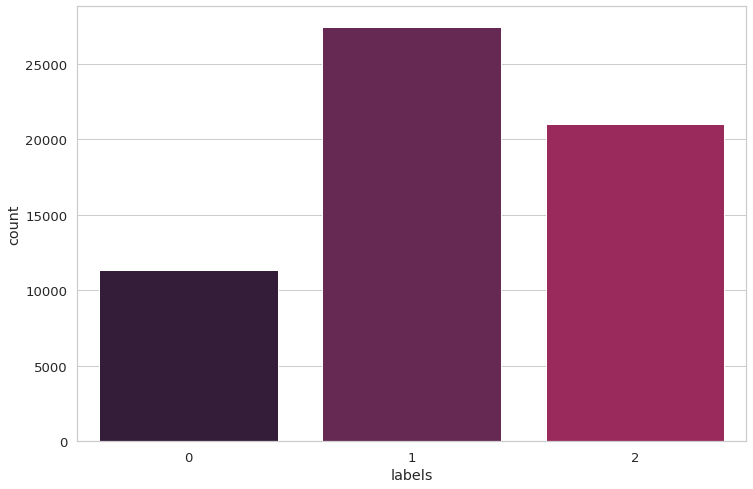

In [6]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='rocket', font_scale=1.2)

sns.countplot(df.label)
plt.xlabel('labels')


In [9]:
# balance the classes

class_1,class_2,class_0 = df.label.value_counts()
c0 = df[df['label'] == 0]
c2 = df[df['label'] == 2]
c1 = df[df['label'] == 1]

df_1 = c1.sample(class_0 + 1500)
df_2 = c2.sample(class_0)
undersampled_df = pd.concat([df_1,df_2,c0],axis=0)

df = undersampled_df.sample(frac=1, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


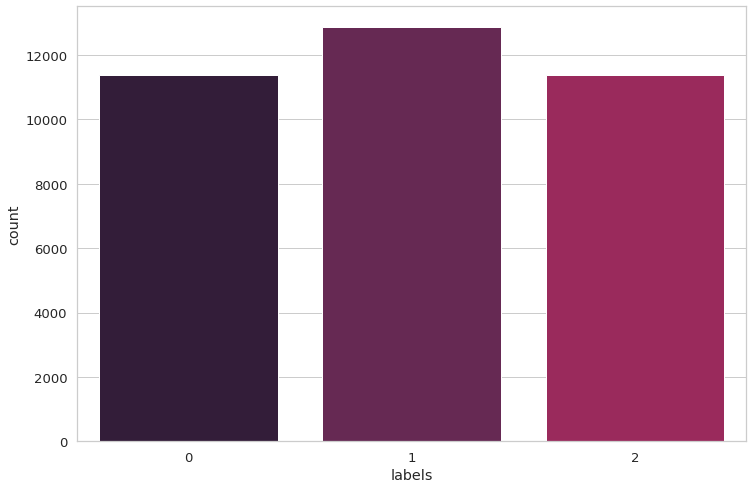

In [8]:

sns.countplot(df.label)
plt.xlabel('labels');


In [12]:
def text_preprocessing(text):

    import re

    text = re.sub(r'\\(?!u)','',text)

    # Remove em dash
    text = re.sub(r'—|—', ' ', text)

    # Remove all occurances of "
    text = re.sub(r'\"|“|”|…'," ",text)
   
    # Remove emoticons and emojis

    text = re.sub(r':P|:-P|😂|🤣',' joking ',text)

    text = re.sub(r'<3|< 3|❤️|💖|😍|💕|😘|💕|💝|💗|💜|💙|🖤|💚|💛|🤍',' love ', text) 

    text = re.sub(r'[😁😃😄😆😊😸😺😊😀😋🥰☺️]','  Happy . ', text)
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))','  Happy . ', text)
    text = re.sub(r'(:\s?D|:-?D|x-?D)','  Happy . ', text)


    text = re.sub(r'[😥😣😓😔😕☹️🙁😖😞😟😢😭😩😵😡😿😫🤢😨😱]','  Sad . ', text)
    text = re.sub(r'(:\(|:-\(|\):|\)-:)','  Sad . ', text)
    text = re.sub(r'(:,\(|:\'\(|:"\()','  Sad . ', text)

    # Remove every pther emoji
    text = re.sub('[\U0001F600-\U0001FFFF]'," ", text)
    text = re.sub('[\U0001F300-\U0001F5FF]'," ", text)
    
    # Codecs
    text = re.sub(r'\\(?!u)','',text)
    import codecs
    text = codecs.unicode_escape_decode(text)[0]

    #remove @usermentions
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Remove URLs
    text = re.sub(r'((https?://[^\s]+)|(www\.[^\s]+))','',text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    
    # Remove hash (#) symbol
    text = re.sub(r'#', ' ', text).strip()

    # Remove trailing dots
    text= re.sub("[.]+", ". ",text)    

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [13]:
text_preprocessing("@traitor_thot The novel coronavirus got her... 😔")

'The novel coronavirus got her. Sad .'

In [14]:
text_preprocessing("#TaiwanCanHelp Feeling😱😰after reading this, 😷 \" As Wuhan Virus Spreads, Taiwan Has No Say at WHO. Chinese pressure keeps Taipei out of international organizations—putting everyone at more risk.\"😷 https://t.co/DRSW0fvbiU https://t.co/7JJi2ltIxl")

'TaiwanCanHelp Feeling Sad . after reading this, As Wuhan Virus Spreads, Taiwan Has No Say at WHO. Chinese pressure keeps Taipei out of international organizations putting everyone at more risk.'

*Splitting* data to train, validation, and test

In [17]:
from sklearn.model_selection import train_test_split

X = df.text.values
y = df.label.values

# Train: 80% Test: 20%
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state=42
)

# Test: 50% Validation: 50%
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=42
)

In [18]:
X_train = df_train['text'].to_numpy()
X_val = df_val['text'].to_numpy()

y_train = df_train['label'].to_numpy()
y_val = df_val['label'].to_numpy()

y_test = df_test['label'].to_numpy()

### Connecting to *GPU*

In [19]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


### BERT

Tokenizer

In [20]:
# Load the BERT tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
# Concatenate all train data and test data
all_tweets = df.text.values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(text_preprocessing(sent), add_special_tokens=True) for sent in all_tweets]

# Find the maximum length

max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  79


In [22]:
# Specify max length to trancuate/pad to
MAX_LEN = 85 

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:

        # encode_plus will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text_preprocessing(r""+sent),   # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Run function `preprocessing_for_bert` on the data

print('Tokenizing data...')

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(df_test.text)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


PyTorch Dataloader

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor

train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks,test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

BERT Classifier architecture

In [25]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class

# BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size on the output. 
# The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.
# We create a single-hidden-layer feed-forward neural network with 0.3 dropout as our classifier.

class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-cased',return_dict=False)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H, D_out)
        )


    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 25.3 ms, sys: 1.01 ms, total: 26.3 ms
Wall time: 28 ms


Optimizer & Learning Rate Scheduler

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-5,    # BERT paper recommends 2e-5 or 3e-5 or 5e-5, but we tested with 1e-5 as well
                      eps=1e-8 
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop

In [27]:
epoch_number = 3

In [28]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


Training:

* Unpack our data from the dataloader and load the data onto the GPU
* Zero out gradients calculated in the previous pass
* Perform a forward pass to compute logits and loss
* Perform a backward pass to compute gradients (loss.backward())
* Clip the norm of the gradients to 1.0 to prevent “exploding gradients”
* Update the model’s parameters (optimizer.step())
* Update the learning rate (scheduler.step())

In [29]:

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        #               Training

        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        #               Evaluation
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


Evaluation:

* Unpack our data and load onto the GPU
* Forward pass
* Compute loss and accuracy rate over the validation set

In [30]:

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### **Training** ( fine-tuning )

In [31]:
set_seed()    # Set seed for reproducibility - default: 42
bert_classifier, optimizer, scheduler = initialize_model(epochs=epoch_number)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a f

In [ ]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=epoch_number, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.099823   |     -      |     -     |   5.41   
   1    |   40    |   1.079144   |     -      |     -     |   5.17   
   1    |   60    |   1.048377   |     -      |     -     |   5.24   
   1    |   80    |   1.025588   |     -      |     -     |   5.26   
   1    |   100   |   0.939539   |     -      |     -     |   5.32   
   1    |   120   |   0.869716   |     -      |     -     |   5.38   
   1    |   140   |   0.847265   |     -      |     -     |   5.42   
   1    |   160   |   0.844194   |     -      |     -     |   5.43   
   1    |   180   |   0.874926   |     -      |     -     |   5.41   
   1    |   200   |   0.791333   |     -      |     -     |   5.36   
   1    |   220   |   0.816237   |     -      |     -     |   5.31   
   1    |   240   |   0.788080   |     -      |     -     |   5.28   


### Evaluation

In [32]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [33]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
tensor = torch.from_numpy(probs)
ytest = torch.max(tensor, dim=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = ['negative', 'neutral', 'positive']
print(classification_report(df_test.label, ytest.indices, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.76      0.77      0.77      1097
     neutral       0.68      0.67      0.67      1276
    positive       0.79      0.78      0.78      1188

    accuracy                           0.74      3561
   macro avg       0.74      0.74      0.74      3561
weighted avg       0.74      0.74      0.74      3561



In [ ]:
#Plot confusion matrix

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="BuPu")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

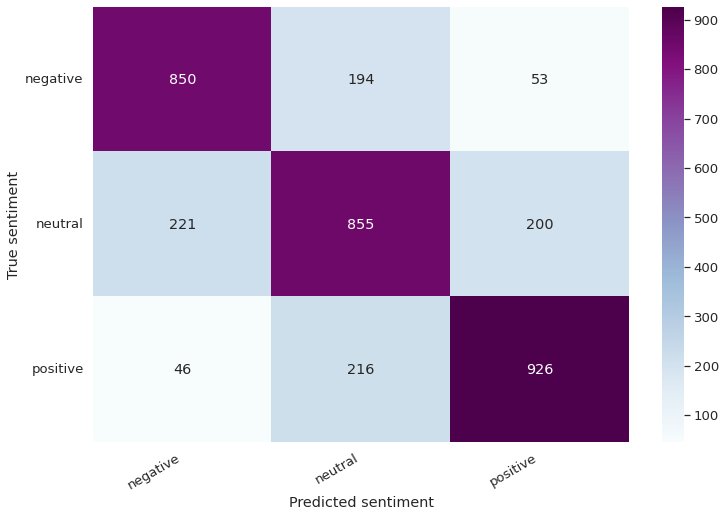

In [ ]:
cm = confusion_matrix(df_test.label,  ytest.indices)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Saving and Loading the model

In [ ]:
torch.save(bert_classifier,'/content/drive/MyDrive/NLP/TweetEval/1-3ep0.2(T1nodot)')

In [ ]:
# modeLoaded = torch.load('/content/drive/MyDrive/NLP/TweetEval/1-3ep0.2(T1nodot)')

### Notebook References

ref: 

https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

http://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8bwa6Rts-02-

